In [1]:
import csv
import timeit
import glob
import torch
import torch.nn as nn
import snntorch as snn
from classes.Sine_Wave_Dataset import SineWave0
from classes.Custom_Loss import CustomLoss_all,CustomLoss_task
from classes.RSNN2 import RSNN2
from torch.utils.data import Dataset, DataLoader
from classes.helper1 import simple_branching_param, fano_factor

loss_task = CustomLoss_task.CustomLoss_task()

dataset0 = SineWave0.SineWaveDataset0('train_data/train_data_sine_hpc0C.csv')
dataloader0 = DataLoader(dataset0, batch_size=25, shuffle=True)

net = RSNN2()

    # optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()),lr=0.1)
optimizer = torch.optim.Adam( net.parameters(),lr=0.02)
num_epochs = 2
#implement sparsity
sparsity_list = []
num_timesteps = 300

weights = net.rlif1.recurrent.weight.data

loss_list = []
synch_list = []
rate_list = []
crit_list = []
c = 0

for epoch in range(num_epochs):
    mse_epoch_loss = 0
    rate_epoch_loss = 0
    synchrony_epoch_loss = 0
    criticality_epoch_loss = 0

    for i, (inputs, targets) in enumerate(dataloader0):
        inputs, targets = inputs, targets
        optimizer.zero_grad()

        outputs = torch.empty(0,dtype=torch.float32,requires_grad=True)
        firing_rate_per_batch = torch.empty(0,dtype=torch.float32,requires_grad=True)
        criticality_per_batch = torch.empty(0,dtype=torch.float32,requires_grad=True)
        synchrony_per_batch = torch.empty(0,dtype=torch.float32,requires_grad=True)

        for input,target in zip(inputs, targets):

            output, spikes = net(input)
            # time_forward_network.append(timeit.default_timer() - start_forward)

            spikes = spikes.T
            outputs = torch.cat((outputs, output.view(1, -1)))

            if c==0:
                net.naive_spikes= spikes
                net.naive_output = outputs
                net.naive_targets= targets
                c+=1

            # 2. Firing Rate
            firing_rate = torch.sum(spikes) / torch.tensor(100000,dtype=torch.int)
            firing_rate = firing_rate.reshape([1])
            firing_rate_per_batch = torch.cat((firing_rate_per_batch, firing_rate))

            
            # 3. Criticality
            criticality = simple_branching_param(1, spikes)
            criticality = criticality.reshape([1])
            criticality_per_batch= torch.cat((criticality_per_batch, criticality))
            
            # 4. Synchrony -- Fano Factor
            synchrony_fano_factor = fano_factor(num_timesteps, spikes)
            synchrony_fano_factor = synchrony_fano_factor.reshape([1])
            synchrony_per_batch = torch.cat((synchrony_per_batch,synchrony_fano_factor))

            

        loss = loss_task(outputs, targets, criticality_per_batch, firing_rate_per_batch, synchrony_per_batch)
        
        print(i,"_loss:",loss)
        loss.backward()
        zero_idxs = torch.where(weights == 0, 1, 0)  # Create a matrix to identify where zeroes are initialized in weight matrix
        optimizer.step()

        weights[zero_idxs==True] = 0
        net.positive_negative_weights()

    # start_save = timeit.default_timer()
    # Save accumulated data to an npz file
    # np.savez(f'data/level{step_dataloader + 1}_loss{criterium}_epoch{epoch}.npz',
    #     batch_loss=batch_loss_list,
    #         task_batch_loss=task_batch_loss_list,
    #         rate_batch_loss=rate_batch_loss_list,
    #         synchrony_batch_loss=synchrony_batch_loss_list,
    #         criticality_batch_loss=criticality_batch_loss_list,
    #         spikes=spikes_list,
    #         input_weights=input_weights_list,
    #         rec_weights=rec_weights_list,
    #         output_weights=output_weights_list,
    #         inputs=inputs_list,
    #         outputs=outputs_list,
    #         targets=targets_list)

    # time_save.append(timeit.default_timer() - start_save)
    print(f'Epoch{epoch}_complete')

0 _loss: tensor(1205.8199, grad_fn=<MulBackward0>)
1 _loss: tensor(1380.3745, grad_fn=<MulBackward0>)
2 _loss: tensor(1513.1718, grad_fn=<MulBackward0>)
3 _loss: tensor(1512.7125, grad_fn=<MulBackward0>)
Epoch0_complete
0 _loss: tensor(1360.7899, grad_fn=<MulBackward0>)
1 _loss: tensor(1416.2635, grad_fn=<MulBackward0>)
2 _loss: tensor(1480.8453, grad_fn=<MulBackward0>)
3 _loss: tensor(1283.0834, grad_fn=<MulBackward0>)
Epoch1_complete


torch.Size([300, 200])


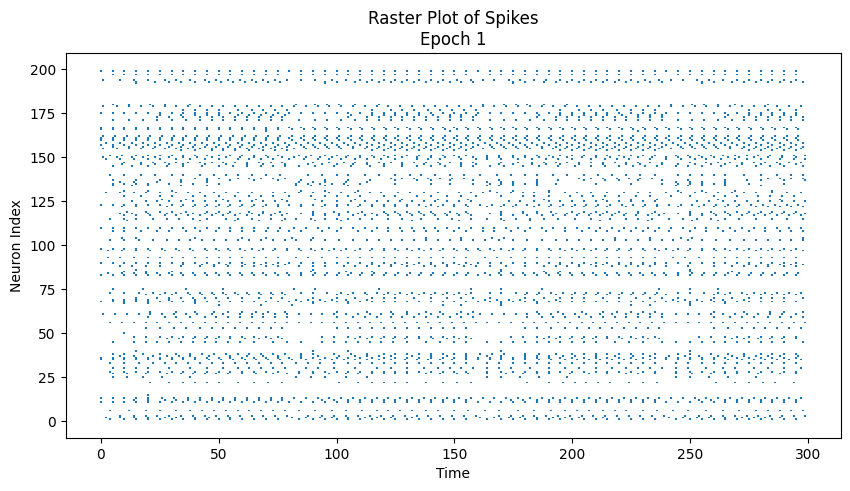

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from snntorch import spikeplot as splt
import os

print(net.spk1_rec.shape)
spikes = net.spk1_rec.T

plt.figure(figsize=(10, 5))
for neuron, spike_train in enumerate(spikes):
    spike_times = np.where(spike_train > 0)[0]  # Assuming spikes are indicated by positive values
    plt.vlines(spike_times, neuron + 0.5, neuron + 1.5)

plt.title(f'Raster Plot of Spikes\nEpoch {epoch}')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.show()